# Inference of Gene Regulatory Network using Kinetic Ising Model


In [1]:
from datetime import date

print("Last run date:", date.today())

Last run date: 2023-05-31


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

import sys
sys.path.append('../')

import lib.NetAnalysis as na
# from lib.import_funcs import *
import lib.fun_plotting as fun_plotting
from lib.ml_wrapper import asynch_reconstruction
import lib.figs_funcs as figfunc
import lib.funcs_general as funcs_general
import lib.funcs_ko as funcs_ko
import lib.minibulk_funcs as mb


%load_ext autoreload
%autoreload 2

matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

# Initial information

In [3]:
path      = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/" 
path_data = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/DATA/"

In [4]:
# genes of OUR dataset
genes_order = np.loadtxt(path_data+"general_info/genes_order.csv", dtype="str") #selected genes

# time steps
time=["00h", "06h", "12h", "24h", "48h"]

# Genes Classification
naive = ["Klf4", "Klf2", "Esrrb", "Tfcp2l1", "Tbx3", "Stat3", "Nanog", "Sox2"]
formative = ["Nr0b1", "Zic3", "Rbpj", "Utf1", "Etv4", "Tcf15"]
committed = ["Dnmt3a", "Dnmt3b", "Lef1", "Otx2", "Pou3f1", "Etv5"]



# Preprocessing Data

## Bulk Data

In [5]:
imp_genes = np.loadtxt(path_data+"general_info/imp_genes.csv", dtype="str")

file_name = path_data+"input_data/geni_IMP.xlsx"
df_bulk_all = pd.read_excel(file_name).set_index(imp_genes).reindex(genes_order)

df_bulk = df_bulk_all.iloc[:,2: ]
df_bulk.head(4)

# df2iL = df.iloc[:,2:18]
# df2i = df.iloc[:,18:]
# ntime=np.array([0, 0, 24, 24, 36, 36, 48, 48, 60, 60, 72, 72, 84, 84, 96, 96])



,GM_2iL_2,GM_2iL_1,GM_24h_2iL_2,GM_24h_2iL_1,GM_36h_2iL_2,GM_36h_2iL_1,GM_48h_2iL_2,GM_48h_2iL_1,GM_60h_2iL_2,GM_60h_2iL_1,...,GM_36h_2i_1,GM_36h_2i_2,GM_48h_2i_1,GM_48h_2i_2,GM_60h_2i_1,GM_60h_2i_2,GM_72h_2i_1,GM_72h_2i_2,GM_84h_2i_1,GM_84h_2i_2
Klf4,721.246075,790.448527,362.034812,507.580169,338.426474,275.595044,109.118435,141.201368,31.593545,46.465603,...,15.825195,7.814844,19.079327,14.208553,38.803582,25.553683,17.314668,14.76264,31.121266,16.477378
Klf2,300.890974,288.413501,124.602767,102.125740,87.270395,86.229124,51.552016,27.900029,31.593545,34.418965,...,25.056559,32.040862,42.928486,27.909658,39.896640,34.467758,16.527638,14.76264,13.103691,5.703708
Esrrb,179.939742,201.400614,103.999160,83.834562,47.694286,52.413781,24.916808,11.228061,6.651273,6.453556,...,3.956299,3.125938,4.769832,1.522345,2.186117,4.159902,3.148121,1.84533,1.637961,3.168726
Tfcp2l1,797.584148,796.803401,135.395133,111.271328,69.511885,70.166836,22.339207,18.713434,6.097000,6.453556,...,7.912597,5.470391,6.359776,6.089380,7.104881,7.725532,4.722182,9.22665,12.284710,8.238689


## Raw Data

In [6]:
df_raw = pd.read_csv(path_data + "GE_data/imp_genes_raw.csv", header=0, index_col=0, sep=",").reindex(genes_order)
# time_sep = np.loadtxt(path+"GE_data/time_sep.txt", dtype=np.int32)
df_raw.index.name = None

In [7]:
# PST
w_size=150
pst_df = pd.read_csv(path_data+'input_data/cellinfo_pseudotime_3no2CLC_22_09_22.txt',
                              header = 0, sep = ' ', quotechar = '"', 
                              names = ["barcodes", "time", "pst"])

pst_df = pst_df.sort_values(by=['pst'])

# riordino dataframe 
column_names = pst_df["barcodes"]
df_raw_pst = df_raw.reindex(columns = column_names)

df_raw_mb_pst = df_raw_pst.rolling(window = w_size, axis=1).mean().dropna(axis=1)
df_raw_mb_pst = pd.DataFrame(df_raw_mb_pst, index=df_raw_pst.index)
df_raw_mb_pst.head(3)


barcodes,GGCGTCAGTCAACGCC,CTCATGCGTCAGGTAG,CTGCCATAGACCGCCT,AGCCAATCAAATCAGA,CGGGTCATCTGGAGAG,TCATTTGTCATCGGGC,AGCATCAAGTACTGGG,ATTCAGGTCGGTTAGT,TCGATTTTCAATCCGA,TATCCTACATAGGTTC,...,TTTGACTTCGCCACTT,GCCATTCTCATTCACT,GAAACCTGTTGTGCCG,CAACCAAAGCCTCACG,TCCTCTTTCGTCCATC,CTAACCCCACAATGCT,CCACACTCACACCAGC,CACGTTCAGCCGAACA,TGATTCTTCCGTTTCG,CTTGATTCACCATTCC
Klf4,1.340000,1.340000,1.353333,1.353333,1.366667,1.406667,1.426667,1.426667,1.426667,1.413333,...,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.213333,0.213333
Klf2,1.233333,1.240000,1.226667,1.226667,1.233333,1.266667,1.260000,1.260000,1.280000,1.286667,...,0.633333,0.626667,0.606667,0.606667,0.580000,0.580000,0.573333,0.573333,0.560000,0.553333
Esrrb,0.240000,0.246667,0.253333,0.246667,0.233333,0.246667,0.260000,0.260000,0.260000,0.260000,...,0.206667,0.206667,0.206667,0.206667,0.206667,0.213333,0.213333,0.220000,0.226667,0.226667



## Normalization

In [8]:
# load the Gene Expression data Log Normalized: the columns are the cells and the rows are the genes
df_lN = pd.read_csv(path_data + "GE_data/imp_genes_logNorm.csv", header=0, index_col=0, sep=",").reindex(genes_order)
df_lN.index.name=None

df_lN.head(3)

# load the Gene Expression data Psi Normalized: the columns are the cells and the rows are the genes
df_pN = pd.read_csv(path_data + "GE_data/imp_genes_PsiNorm.csv", header=0, index_col=0, sep=",").reindex(genes_order)
df_pN.index.name = None

df_pN.head(3)


,AAACCCAGTGACCGTC,AAACGAAAGCGCGTTC,AAACGAACAAGCACCC,AAACGAATCAAGTCGT,AAACGCTTCCGTGACG,AAAGAACGTCAGATTC,AAAGAACTCACTTGTT,AAAGGATCAAATCAAG,AAAGGATTCTGAACGT,AAAGGGCAGCAGGCAT,...,TTTGACTGTCAGCTTA,TTTGACTGTGTTATCG,TTTGACTTCGCCACTT,TTTGATCGTTCTCCAC,TTTGGTTAGAGAGCGG,TTTGGTTGTGATCATC,TTTGGTTTCACGGGCT,TTTGGTTTCCAACACA,TTTGTTGCATCGAAGG,TTTGTTGCATCTCATT
Klf4,1.485415,1.338896,0.000000,0.855192,2.511880,1.881212,0.000000,1.267982,1.684245,0.000000,...,0.0,1.592437,1.025867,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
Klf2,1.485415,0.000000,1.338774,1.388465,0.000000,1.479866,2.463433,2.385357,1.075095,1.705082,...,0.0,2.008406,1.025867,0.0,0.0,0.0,2.182156,0.000000,0.0,1.578242
Esrrb,0.000000,1.338896,0.000000,1.388465,1.360576,0.000000,0.000000,1.267982,0.000000,0.000000,...,0.0,1.005610,0.000000,0.0,0.0,0.0,1.123956,0.952262,0.0,0.000000


## MB

In [9]:
# raw
df_raw_mb = mb.mov_avg(np.array(df_raw, dtype=int), wind=w_size)
df_raw_mb = pd.DataFrame(df_raw_mb, index=df_raw.index)
df_raw_mb.head(3)

# log normalized
df_lN_mb = mb.mov_avg(np.array(df_lN, dtype=int), wind=w_size)
df_lN_mb = pd.DataFrame(df_lN_mb, index=df_lN.index)
df_lN_mb.head(3)
# psi normalized
df_pN_mb = mb.mov_avg(np.array(df_pN, dtype=int), wind=w_size)
df_pN_mb = pd.DataFrame(df_pN_mb, index=df_pN.index)
df_pN_mb.head(3)

,0,1,2,3,4,5,6,7,8,9,...,9884,9885,9886,9887,9888,9889,9890,9891,9892,9893
Klf4,0.826667,0.760000,0.720000,0.813333,0.713333,0.793333,0.680000,0.746667,0.846667,0.773333,...,0.200000,0.146667,0.140000,0.160000,0.100000,0.146667,0.186667,0.173333,0.126667,0.180000
Klf2,1.066667,0.953333,0.980000,1.020000,1.060000,0.920000,0.980000,1.100000,0.946667,1.020000,...,0.453333,0.380000,0.493333,0.393333,0.366667,0.393333,0.486667,0.433333,0.406667,0.453333
Esrrb,0.220000,0.293333,0.206667,0.253333,0.233333,0.213333,0.213333,0.293333,0.213333,0.266667,...,0.120000,0.133333,0.100000,0.106667,0.120000,0.080000,0.126667,0.100000,0.093333,0.100000


## Pseudotime

In [10]:
# load the Gene Expression data log normalized: the columns are the cells and the rows are the genes
df_lN_pst= pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST.csv", header=0, index_col=0, sep=",")


# load the Gene Expression data Psi Normalized: the columns are the cells and the rows are the genes
df_pN_pst= pd.read_csv(path_data + "GE_data/processed/imp_genes_PsiNorm_PST.csv", header=0, index_col=0, sep=",")

df_pN_pst.head(3)

,TTCAGGAAGCAGTACG,GTAGATCAGTAGGTTA,CGAAGGACACGGGCTT,GTCGCGAGTCGTCTCT,CCTTCAGGTCCAGCGT,CTCCGATAGCATCCTA,CAACGATAGATGAACT,GTGTCCTAGAATTGCA,TGCGACGTCGTGTCAA,CTCAATTAGGCTAAAT,...,AACAAAGAGAGCGACT,TCATACTAGGTGTGAC,GCCATTCAGCCAGAGT,AACAGGGGTGCACGCT,GATCATGTCTGTAACG,GATTCGAAGATACAGT,GCCAGGTAGAAGAACG,CGTGCTTTCGACGTCG,AGGGTGACAATACGAA,CCACAAAAGCGTGAAC
Klf4,0.000000,0.0,0.000000,0.0,2.534856,2.337277,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,1.502543,0.0,0.000000,0.0,0.0,0.0,0.0
Klf2,1.705748,0.0,3.095388,0.0,1.377622,1.233372,0.0,0.0,2.131445,0.000000,...,1.308057,0.0,0.0,1.502543,0.0,1.389484,0.0,0.0,0.0,0.0
Esrrb,0.000000,0.0,0.000000,0.0,0.000000,1.233372,0.0,0.0,2.131445,1.116785,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


## PST + MB

In [11]:
# Window size for Mini-Bulk
mb_wind = 150

# Threshold for half max
thr = 0.5 

In [12]:
# Mini-Bulk
# load the Gene Expression data log normalized + Pseudo-Time: the columns are the cells and the rows are the genes
df_lN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB.csv", header=0, index_col=0, sep=",")

# load the Gene Expression data Psi Normalized + Pseudo-Time: the columns are the cells and the rows are the genes
df_pN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB.csv", header=0, index_col=0, sep=",")


print("LogNorm dims: ", df_lN_mb_pst.shape, "\nPsiNorm dims: ", df_pN_mb_pst.shape)

LogNorm dims:  (24, 9547) 
PsiNorm dims:  (24, 8124)


## Binarization (Half-max)

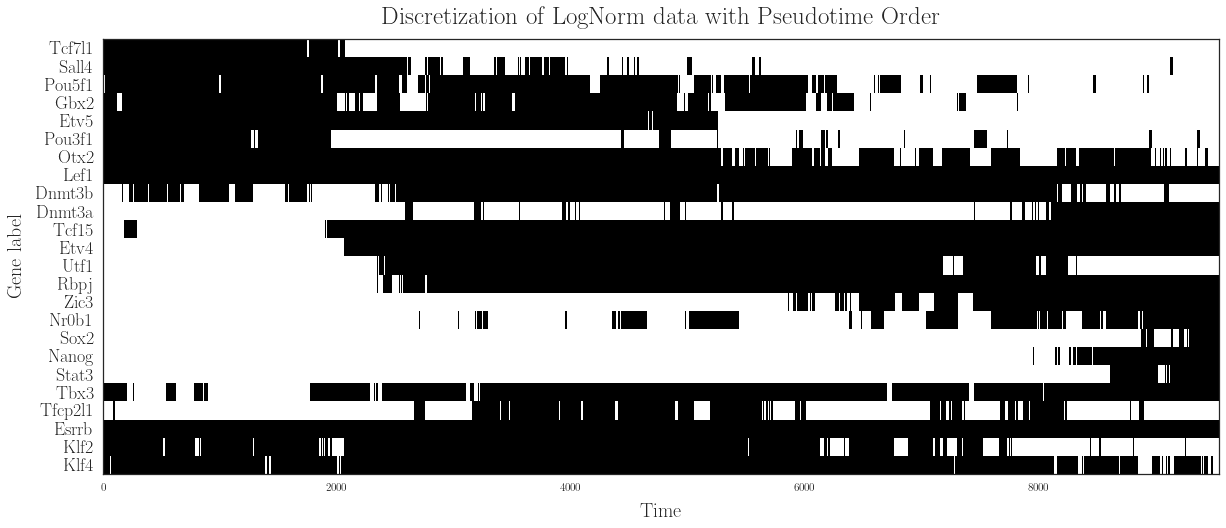

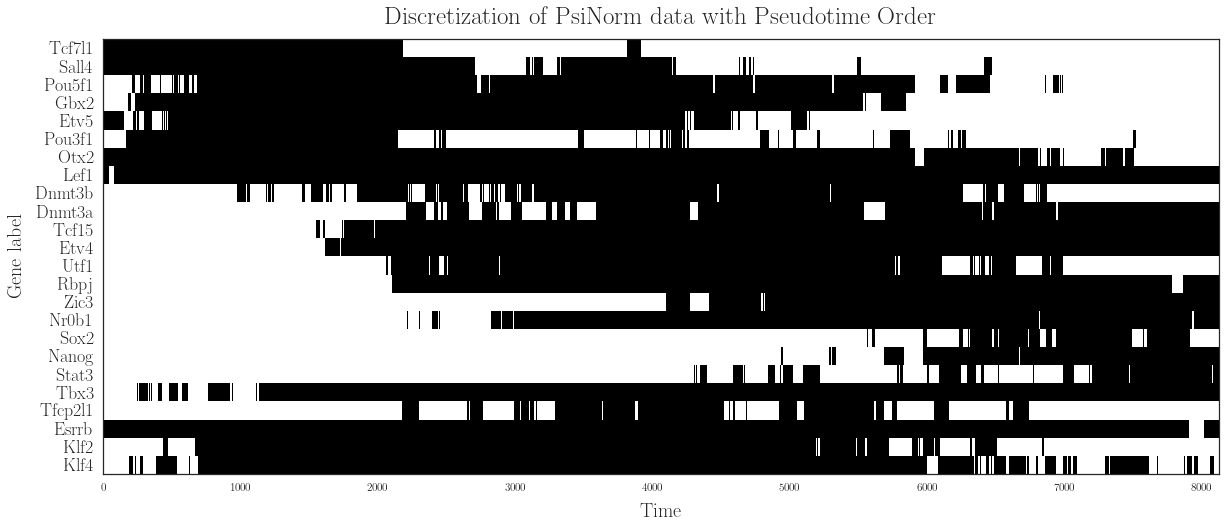

In [13]:
spins_df_lN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB_Spins.csv", header=0, index_col=0, sep=",")

fun_plotting.raster_plot(np.array(spins_df_lN_mb_pst), 'Discretization of LogNorm data with Pseudotime Order', 1, genes_order[::-1])
plt.show()


spins_df_pN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB_Spins.csv", header=0, index_col=0, sep=",")

fun_plotting.raster_plot(np.array(spins_df_pN_mb_pst), 'Discretization of PsiNorm data with Pseudotime Order', 1, genes_order[::-1])
plt.show()



## Randomization

In [14]:
spins_df_lN_mb_pst_shuffle = np.load(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB_Spins_RND50Test.npy")
spins_df_pN_mb_pst_shuffle = np.load(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB_Spins_RND50Test.npy")
 
Ntest = spins_df_lN_mb_pst_shuffle.shape[0] 

print(Ntest)



50


In [15]:
check=True
if check:
    # Check the reshuffle
    print(funcs_general.check_shuffle(spins_df_lN_mb_pst_shuffle, Ntest))
    print(funcs_general.check_shuffle(spins_df_pN_mb_pst_shuffle, Ntest))
    
    # zero expected if everithing is working fine

0.0
0.0


In [16]:
show = False
if show:
    for ii in range(0, Ntest, 60):
            fun_plotting.raster_plot(np.array(spins_df_lN_mb_pst_shuffle[ii,:,:]), 'Discretization of LogNorm data with PST - RND '+str(ii+1), 1, genes_order[::-1])
            plt.show()    
            fun_plotting.raster_plot(np.array(spins_df_pN_mb_pst_shuffle[ii,:,:]), 'Discretization of PsiNorm data with PST - RND '+str(ii+1), 1, genes_order[::-1])
            plt.show() 
            

# Experimental Results

## Neighbours interactions

In [17]:
TPtrial_list = ["Stat3 Klf4 1", "Nanog Esrrb 1", "Stat3 Dnmt3b -1", 
                "Nanog Otx2 -1", "Nanog Pou3f1 -1",
                "Stat3 Gbx2 1", "Stat3 Tfcp2l1 1", 
                "Otx2 Pou3f1 1", "Otx2 Dnmt3a 1", 
                "Tcf7l1 Esrrb -1", "Tcf7l1 Klf2 -1", "Tcf7l1 Nanog -1", "Tcf7l1 Nr0b1 -1",  "Tcf7l1 Tfcp2l1 -1",  
                "Rbpj Nanog -1", "Rbpj Tbx3 -1", "Etv5 Lef1 1", "Etv5 Pou3f1 1"]


## Directed Correlations

### Leeb Data

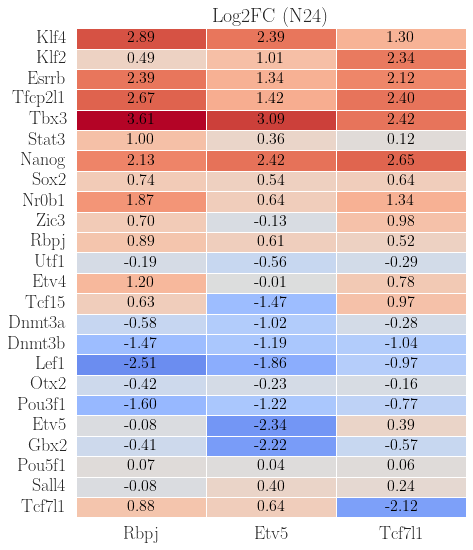

In [18]:
df_KO_N24_Leeb_uncl = pd.read_csv(path_data+'Leeb_Data_Orig/df_KO_N24_uncleaned.csv', index_col=0, header=0)
df_KO_N24_Leeb_uncl.head(2)

plt.figure(figsize=(7,9))
# annotate using 3 decimal places
sns.heatmap(np.array(df_KO_N24_Leeb_uncl).astype(float), annot=True, fmt=".2f", 
            xticklabels=df_KO_N24_Leeb_uncl.columns, yticklabels=df_KO_N24_Leeb_uncl.index, 
           cmap="coolwarm", cbar=False, center=0, linewidth=.5, annot_kws={"size":16, 'color':'black'})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Log2FC (N24)", fontsize=20)
plt.show()


### Kalkan data

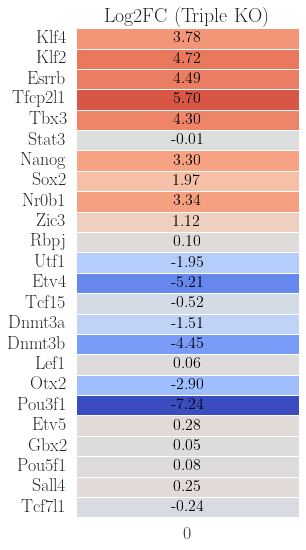

In [19]:
df_tKO_Kalkan = pd.read_csv(path_data+'Kalkan_Data/df_tripleKO_diff.csv', index_col=0, header=0)

plt.figure(figsize=(4,9))
# annotate using 3 decimal places
sns.heatmap(np.array(df_tKO_Kalkan).astype(float), annot=True, fmt=".2f", 
            xticklabels=df_tKO_Kalkan.columns, yticklabels=df_tKO_Kalkan.index, 
           cmap="coolwarm", cbar=False, center=0, linewidth=.5, annot_kws={"size":16, 'color':'black'})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Log2FC (Triple KO)", fontsize=20)
plt.show()

# Hyperparameter values

In [20]:
params = {"LAMBDA" : [0.01, 0.02, 0.03,0.04, 0.05, 0.07, 0.09],
          "lr"     : [0.8, 0.7, 0.6, 0.5, 0.4, 0.3],
          "drop"   : [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99],
          "edrop"  : [15, 20, 25, 30, 35],
          "opt"    : ['MOMENTUM','NADAM'],
          "MOM"    : [0.75, 0.8, 0.85, 0.9, 0.95, 0.99],
          "reg"    : ['L1'],
          "Nepochs": [500, 700, 800, 900, 1200]}


# Results


In [21]:
interaction_thr = 0.0
interaction_thr

0.0

# Cluster Original data (LogNorm)

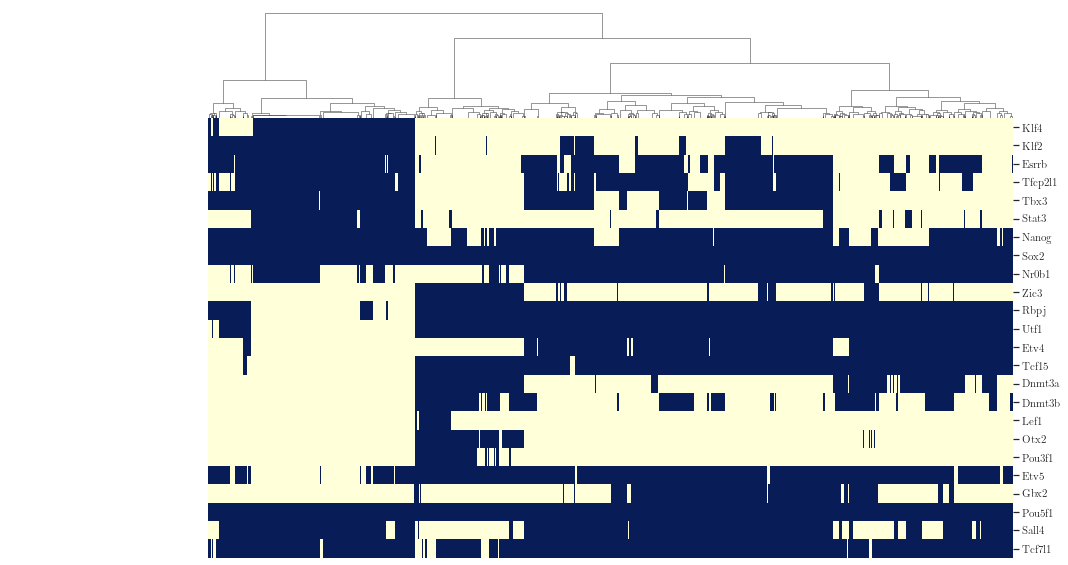

In [22]:
# Perform linkage on your numpy array
Z_original = scipy.cluster.hierarchy.linkage(spins_df_lN_mb_pst.T, method='ward')

# Plot the dendrogram and heatmap
sns.clustermap(spins_df_lN_mb_pst, col_linkage=Z_original, cmap='YlGnBu',
               yticklabels=genes_order, 
               cbar=False, figsize=(15,8), row_cluster=False, xticklabels=False )

plt.xticks([])
plt.yticks([])

plt.show()

# Ising results for "thr0_23_05_09"

In [23]:
## Loading Data for the model selection using the Fraction of correctly inferred interactions
Ntrials = 150
today = "thr0_23_05_09" # "thr1_onlyPST" # or other data
data_type = "pst_mb"
# LOADING data   
lN_arrays_MCIf = np.load(path_data+'OUT_ISING/LogNORM/lN_arrays_'+data_type+'_'+str(today)+'.npz')#+'_thr'+str(interaction_thr*100)+'.npz')
lN_matx_sel_MCIf = lN_arrays_MCIf['array_1']
lN_prec_sel_MCIf = lN_arrays_MCIf['array_2']
lN_int_val_MCIf = lN_arrays_MCIf['array_3']

In [24]:
# load dist
dist = np.load(path_data+'OUT_ISING/LogNORM/dist_CIf_'+data_type+'_'+str(today)+'.npz')
lN_dist_MCIf = dist['arr_0']
lN_dist_MCIf.shape

(150,)

### Scatter plot

No handles with labels found to put in legend.


Spearman corr coeff:  SpearmanrResult(correlation=-0.6517159597961193, pvalue=6.856716255119483e-19)


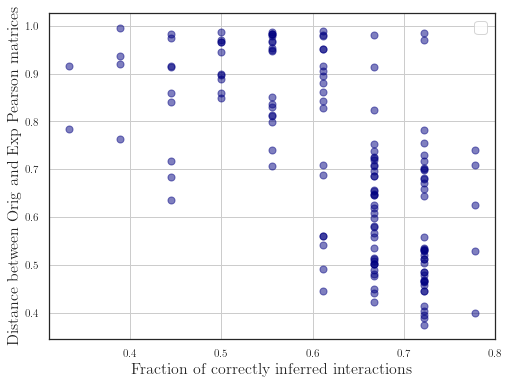

In [25]:
# plt.scatter(lN_prec_sel_MCIf, lN_dist_MCIf)
# plt.xlabel("Fraction of correctly inferred interactions")
# plt.ylabel("Distance between Orig and Exp Pearson matrices")
# plt.grid()
# plt.title("LogNorm data")
# plt.show()
# sperarmann correlation coefficient
print("Spearman corr coeff: ", scipy.stats.spearmanr(lN_prec_sel_MCIf, lN_dist_MCIf, nan_policy='omit'))

def scatter_modelSelection(lN_prec_sel_MCIf, lN_dist_MCIf, color='navy', label=""):
    plt.scatter(lN_prec_sel_MCIf, lN_dist_MCIf, color=color, s=50, alpha=0.5, label=label)
    plt.xlabel("Fraction of correctly inferred interactions", fontsize=16)
    plt.ylabel("Distance between Orig and Exp Pearson matrices", fontsize=16)
    plt.grid()
    plt.legend(fontsize=16)
    # plt.title("LogNorm data", fontsize=20)
    
plt.figure(figsize=(8,6))
scatter_modelSelection(lN_prec_sel_MCIf, lN_dist_MCIf)
plt.show()

# Models selected by CIf

selected indices: 117 CIf value, 0.78 Distance value, 0.62
selected indices: 92 CIf value, 0.78 Distance value, 0.53
selected indices: 56 CIf value, 0.78 Distance value, 0.74
selected indices: 33 CIf value, 0.78 Distance value, 0.40
selected indices: 77 CIf value, 0.78 Distance value, 0.71


No handles with labels found to put in legend.


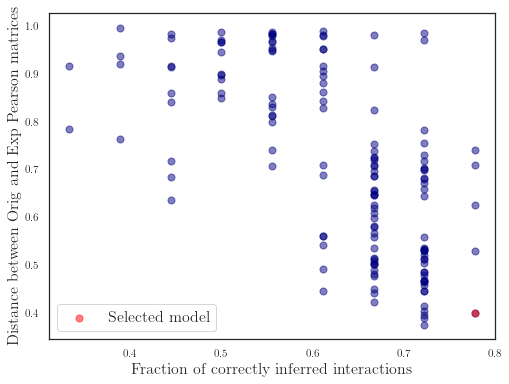

In [26]:
# select models with highest lN_prec_sel_true, fraction of known interactions correctly inferred
Nmodel_MCIf = 5
interaction_thr = 0 # we consider all interactions, even with low values
idxs_MCIf = np.argsort(lN_prec_sel_MCIf)[::-1][:Nmodel_MCIf]

for ii in idxs_MCIf:
    print ("selected indices:", ii,
           f"CIf value, {lN_prec_sel_MCIf[ii]:.2f}",
           f"Distance value, {lN_dist_MCIf[ii]:.2f}")

plt.figure(figsize=(8,6))

scatter_modelSelection(lN_prec_sel_MCIf, lN_dist_MCIf)
scatter_modelSelection(min(lN_prec_sel_MCIf[idxs_MCIf]), min(lN_dist_MCIf[idxs_MCIf]), color='red', label="Selected model")


selected indices: 33


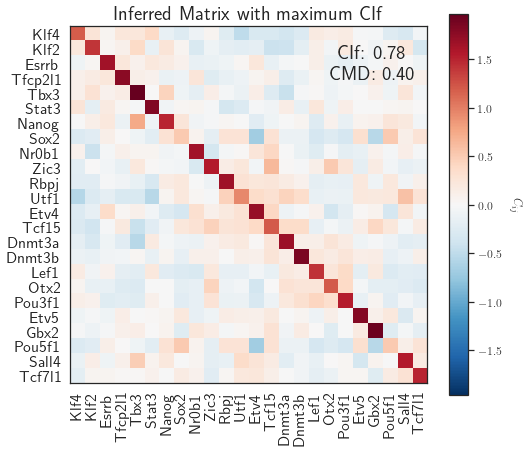

In [27]:
## save the Nmodel_MCIf matrices with the maximum lN_prec_sel_true
Nrow = 1
Ncol = 1
if Ncol ==1:
    Nrow=1
    fig, ax = plt.subplots(nrows=Nrow, ncols=Ncol, figsize=(8,7))
else:
    fig, ax = plt.subplots(nrows=Nrow, ncols=Ncol, figsize=(20, 12))
    
best_model_MCIf = np.zeros((lN_matx_sel_MCIf.shape[1], lN_matx_sel_MCIf.shape[2]))
info_best_model_MCIf = np.zeros((lN_int_val_MCIf.shape[0], lN_int_val_MCIf.shape[1]))
for ii in range(Nmodel_MCIf):
    if idxs_MCIf[ii]==33:
        print("selected indices:", idxs_MCIf[ii])
        best_model_MCIf[:,:] = np.squeeze(lN_matx_sel_MCIf[idxs_MCIf[ii],:,:])
        # plot the interaction matrices
        text = "CIf: {:.2f}\nCMD: {:.2f}".format(lN_prec_sel_MCIf[idxs_MCIf[ii]], lN_dist_MCIf[idxs_MCIf[ii]])   # print the fraction of correctly inferred interactions and the distance

        figfunc.plotmat(best_model_MCIf[:,:], fig, ax, genes_order, "Inferred Matrix with maximum CIf", fix=False)
        ax.text(0.85,0.85, text, transform=ax.transAxes, ha='center', fontsize=20)

        # select lN_int_val_true with the maximum lN_prec_sel_true
        info_best_model_MCIf[:,:] = lN_int_val_MCIf[:,:, idxs_MCIf[ii]]


plt.show()

In [28]:
# Ntrials = 150

# models_selected =[] 
# np.random.seed(20961)  
# for ii in range(Ntrials):
#     par_sel = {}
#     for jj in params.keys():
#         par_sel[jj] = np.random.choice(params[jj])
        
#     if ii in idxs_MCIf and ii == 33:
#         print("Model Selection: Trial ", ii, "params: ", par_sel)
#         print(par_sel)
#         # model
#         model_temp = asynch_reconstruction(np.array(spins_df_lN_mb_pst), delta_t = 1, LAMBDA = par_sel["LAMBDA"], opt = par_sel['opt'], MOM=par_sel["MOM"], reg = 'L1')
#         model_temp.reconstruct(np.array(spins_df_lN_mb_pst), Nepochs = par_sel["Nepochs"], start_lr = par_sel["lr"], drop = par_sel["drop"], edrop = par_sel["edrop"])

#         print("Fraction of correctly inferred interactions: {:.2f}, distance: {:.2f}".format(lN_prec_sel_MCIf[ii], lN_dist_MCIf[ii]))
#         models_selected.append(model_temp) # save the models   

    

/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Model Selection: Trial  33

Params for LogNorm (0)
 {'LAMBDA': 0.07, 'lr': 0.3, 'drop': 0.75, 'edrop': 30, 'opt': 'NADAM', 'MOM': 0.9, 'reg': 'L1', 'Nepochs': 800}


/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/fun_asynch.py:171: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  return 1/delta_t*(np.dot(spins[:,1:], spins[:,:-1].T)/Nsteps - cov)
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Epoch 	 Max J gradient 	 Max h gradient 	 Max change in J 	 Max change in h 	 Likelihood


/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/fun_asynch.py:355: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  gJ = nb_dJ(cov, dot_cov, spins, new_h, new_J, theta)


300 	 0.011243 	 0.002351 	 0.0005 	 0.0002 	 -3.0481
600 	 0.009123 	 0.002031 	 0.0001 	 0.0 	 -3.0724


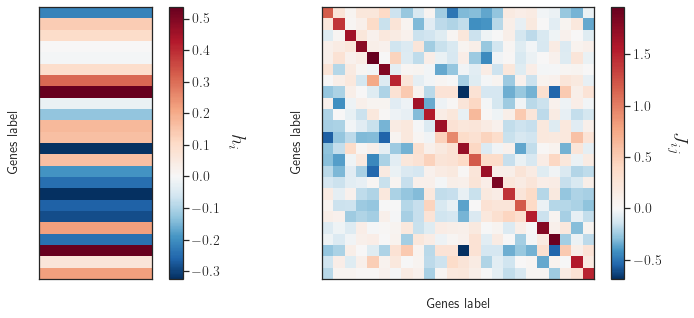

Fraction of correctly inferred interactions: 0.78, distance: 0.40


/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/fun_asynch.py:135: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  slist[:,idx+1] = asynch_glauber_dynamics(h, J, slist[:,idx], delta_t, gamma)


Distance: 0.40


/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [29]:
# Code to save the distance between the original and the simulated matrices for all Ntrials

Ntrials = 50
matx_sel = np.zeros((Ntrials, len(genes_order), len(genes_order)))
info_int  = np.zeros((4, len(TPtrial_list), Ntrials))
tp_val  = np.zeros(Ntrials)
dist  = np.zeros(Ntrials)

N_genes = len(genes_order)
N_ts = 9000 # 9000
N_sim = 10 # 10

cm_original_lN = np.corrcoef(spins_df_lN_mb_pst)
corr_matxs_rnd_lN = np.array([np.corrcoef(spins_df_lN_mb_pst_shuffle[i,:,:]) for i in range(spins_df_lN_mb_pst_shuffle.shape[0])])
noise_dist = np.mean([funcs_ko.sum_squared_abs_diff(cm_original_lN, corr_matxs_rnd_lN[i,:,:]) for i in range(50)])

models_selected = []
np.random.seed(20961)  
for ii in range(Ntrials):
    par_sel = {}
    for jj in params.keys():
        par_sel[jj] = np.random.choice(params[jj])
        
    if ii ==33:
        print("Model Selection: Trial ", ii)
        print("\nParams for LogNorm (0)\n", par_sel)
        
        # model
        model_temp = asynch_reconstruction(np.array(spins_df_lN_mb_pst), delta_t = 1, LAMBDA = par_sel["LAMBDA"], opt = par_sel['opt'], MOM=par_sel["MOM"], reg = 'L1') #opt = 'MOMENTUM', MOM=0.99
        model_temp.reconstruct(np.array(spins_df_lN_mb_pst), Nepochs = par_sel["Nepochs"], start_lr = par_sel["lr"], drop = par_sel["drop"], edrop = par_sel["edrop"])
        print("Fraction of correctly inferred interactions: {:.2f}, distance: {:.2f}".format(lN_prec_sel_MCIf[ii], lN_dist_MCIf[ii]))
        models_selected.append(model_temp) # save the models   
        
        # evaluate the model with the comparison between original and simulated Pearson correlation matrix
        spins_new_lN = np.zeros((N_genes, N_ts, N_sim))
        # generate N_sim new time series of spins using model
        for ll in range(N_sim):
            spins_new_lN[:,:,ll] = model_temp.generate_samples(seed=ll*2, t_size=N_ts)
        # compute the Pearson correlation matrix
        cm_sim_lN = np.zeros((spins_new_lN.shape[0], spins_new_lN.shape[0], spins_new_lN.shape[2]))
        for kk in range(spins_new_lN.shape[2]):
            cm_sim_lN[:,:, kk] = np.corrcoef(spins_new_lN[:,:,kk])
        cm_sim_lN_mean = np.nanmean(cm_sim_lN, axis=2) # mean for simulated correlation matrix

        dist[ii] = np.mean([funcs_ko.sum_squared_abs_diff(cm_original_lN, cm_sim_lN[:,:,i]) for i in range(cm_sim_lN.shape[2])])/ noise_dist # normalize by the noise
        if  np.isnan(cm_sim_lN).sum() > (24*24*spins_new_lN.shape[2])-24*24*0.5*spins_new_lN.shape[2]:
            dist[ii] =np.nan
        print("Distance: {:.2f}".format(dist[ii]))




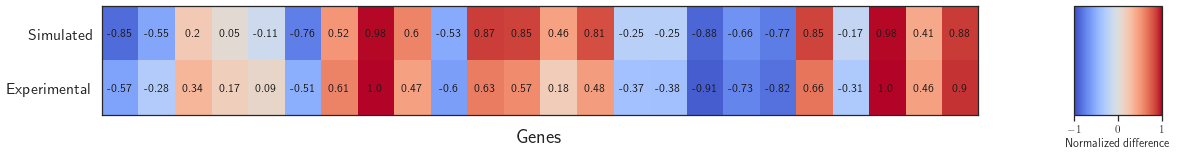

0.9583333333333333


In [30]:
# average per gene of spins_df_lN_mb_pst
avg_spins_df_lN_mb_pst = np.mean(spins_df_lN_mb_pst, axis=1)
avg_spins_df_lN_sim = np.mean(np.mean(spins_new_lN, axis=1), axis=1)
# unique matrix 24x2 with avg_spins_df_lN_mb_pst and avg_spins_df_lN_sim:
funcs_ko.KO_heat_comparison_T(avg_spins_df_lN_sim,avg_spins_df_lN_mb_pst, "", "", Norm=False)

avg_spins_goodness = funcs_ko.fraction_agreement(avg_spins_df_lN_sim, avg_spins_df_lN_mb_pst, genes_order, 0)[3]
print(avg_spins_goodness)

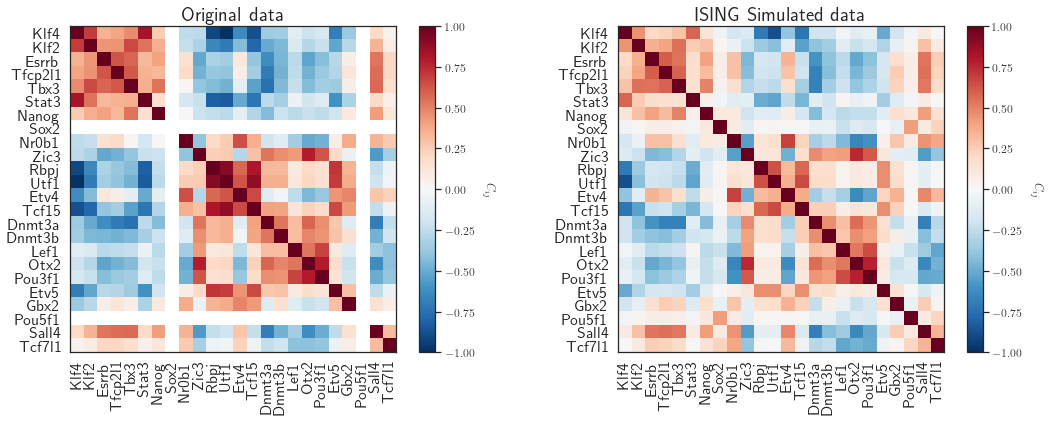

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
# figfunc.plotmat(corr_matxs_rnd_lN_noDiag, fig, ax[0], genes_order, "Random data")
figfunc.plotmat(cm_original_lN, fig, ax[0], genes_order, "Original data", fix = True)

cm_sim_lN_mean = np.nanmean(cm_sim_lN, axis=2)
figfunc.plotmat(cm_sim_lN_mean, fig, ax[1], genes_order, "ISING Simulated data", fix = True)
plt.show()

Model Selection: Trial  0
Fraction of correctly inferred interactions: 0.78, distance: 0.40


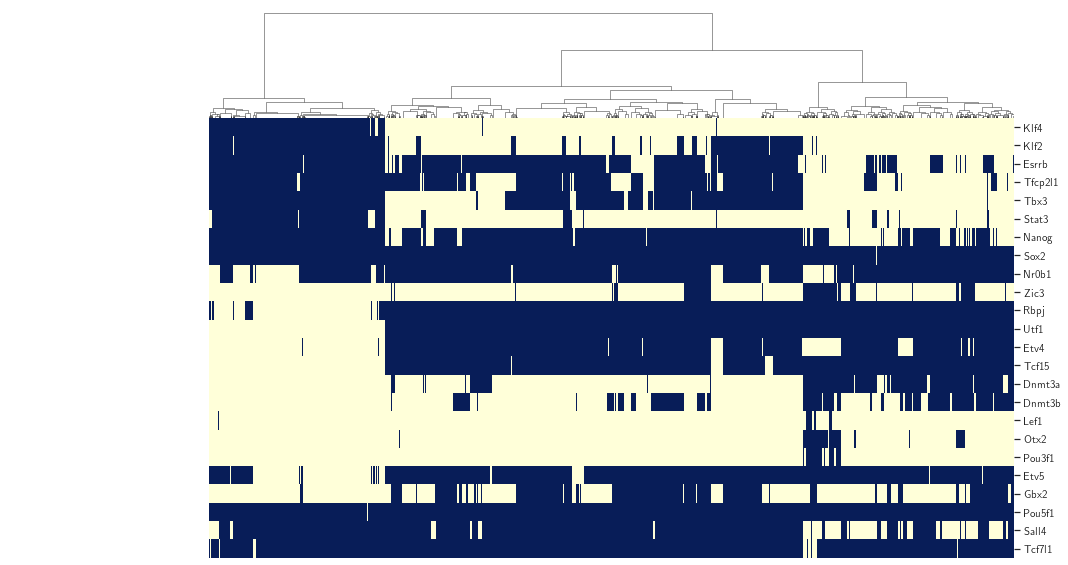

/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/fun_asynch.py:135: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, F), array(float64, 1d, A))
  slist[:,idx+1] = asynch_glauber_dynamics(h, J, slist[:,idx], delta_t, gamma)


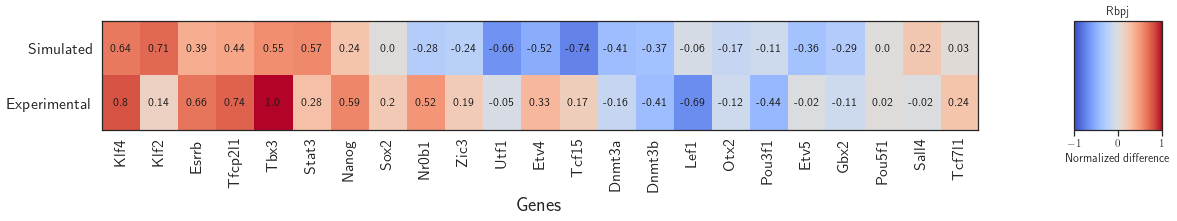

(0.30434782608695654, 0.30434782608695654, 0.043478260869565216, 0.6521739130434783)


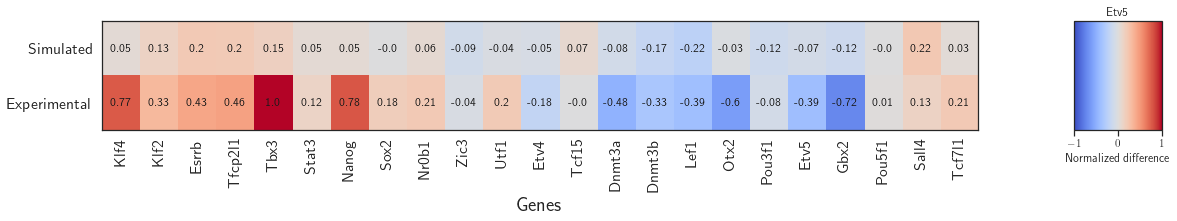

(0.2608695652173913, 0.34782608695652173, 0.043478260869565216, 0.6521739130434783)


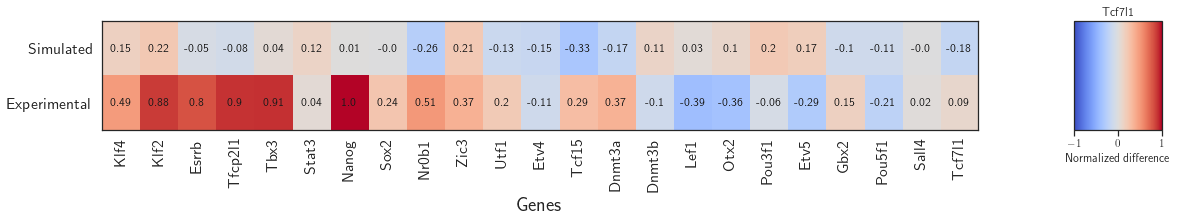

(0.08695652173913043, 0.13043478260869565, 0.043478260869565216, 0.2608695652173913)


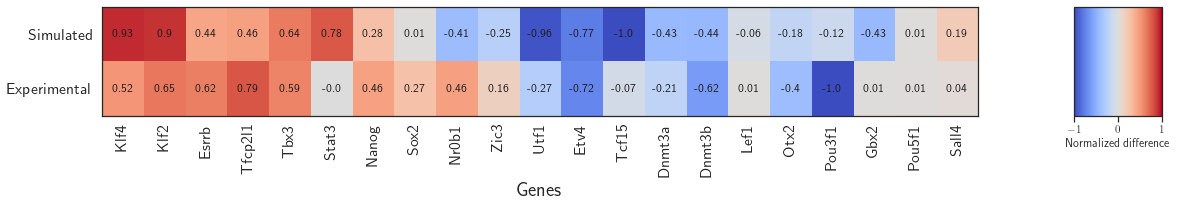

(0.3333333333333333, 0.2857142857142857, 0.047619047619047616, 0.6666666666666667)


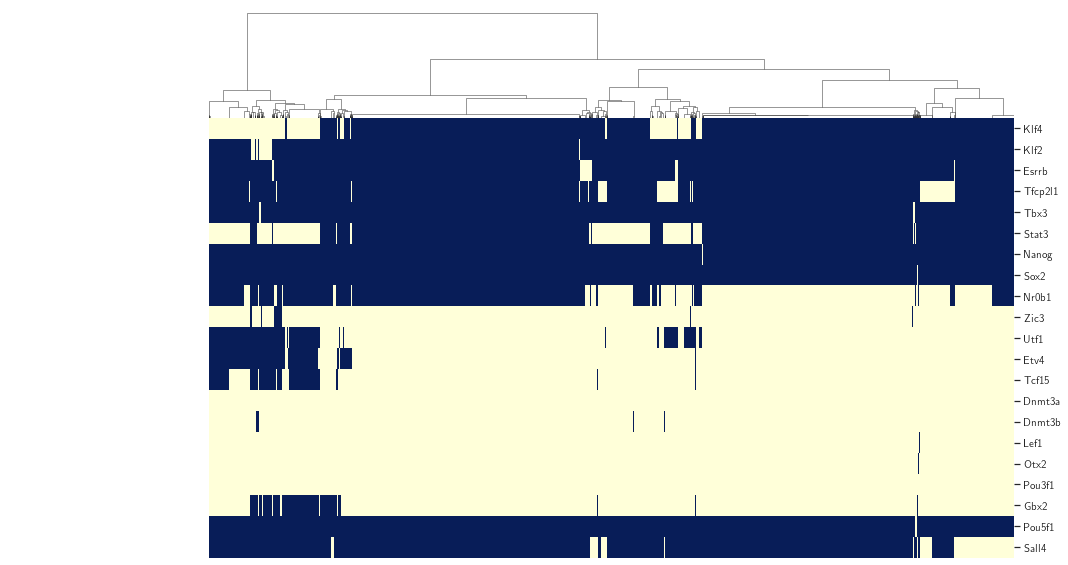

In [32]:
# matx_sel = np.zeros((Ntrials, len(genes_order), len(genes_order)))
# info_int  = np.zeros((4, len(TPtrial_list), Ntrials))
# tp_val  = np.zeros(Ntrials)

N_genes = len(genes_order)
N_ts = 10000
N_sim = 100
N_test_KO = N_sim

spins_new_lN = np.zeros((len(idxs_MCIf),N_genes, N_ts, N_sim))
KO_goodness_MCIf = np.zeros((len(idxs_MCIf), 4))
dist  = np.zeros(Ntrials)

cc=0
for ii in range(Ntrials):        
    if ii in idxs_MCIf:
        if ii == 33:
            print("Model Selection: Trial ", cc)
            for ll in range(N_sim):
                np.random.seed(ll+1234)
                spins_new_lN[cc,:,:,ll] = models_selected[cc].generate_samples(seed=ll*2, t_size=N_ts)
            print("Fraction of correctly inferred interactions: {:.2f}, distance: {:.2f}".format(lN_prec_sel_MCIf[ii], lN_dist_MCIf[ii]))
                
            # Clustering
            # flat spins_new_lN linearizing the dimension 3 (N_sim)
            # all_spins_temp = np.reshape(spins_new_lN[cc,:,:,:], (spins_new_lN.shape[1], spins_new_lN.shape[2]*spins_new_lN.shape[3]), order='F')
            jj=0 # select one of the simulated datasets
            Z = scipy.cluster.hierarchy.linkage(spins_new_lN[cc,:,:,jj].T, method='ward')
            # Z = scipy.cluster.hierarchy.linkage(all_spins_temp.T, method='ward')
            # Note: we are showing just one simulated dataset, but you can do the same for all of them

            # Plot the dendrogram and heatmap
            sns.clustermap(spins_new_lN[cc,:,:, jj], col_linkage=Z, cmap='YlGnBu',yticklabels=genes_order,cbar=False, figsize=(15,8), row_cluster=False,xticklabels=False )
            # sns.clustermap(all_spins_temp, col_linkage=Z, cmap='YlGnBu',yticklabels=genes_order,cbar=False, figsize=(15,8), row_cluster=False,xticklabels=False )
            plt.xticks([])
            plt.yticks([])
            plt.show()
            
            # Single KO
            # Rbpj
            diff_lN_Rbpj, exp_logFC_Rbpj, KO_genes_order_Rbpj = funcs_ko.KO_wrap("Rbpj", 
                                                                                best_model_MCIf[:,:], 
                                                                                models_selected[cc], genes_order, 
                                                                                spins_new_lN[cc,:,:,:], 
                                                                                df_KO_N24_Leeb_uncl,
                                                                                N_test_KO=N_test_KO) 
            
            diff_lN_Etv5, exp_logFC_Etv5, KO_genes_order_Etv5 = funcs_ko.KO_wrap("Etv5", 
                                                                                best_model_MCIf[:,:], 
                                                                                models_selected[cc], genes_order, 
                                                                                spins_new_lN[cc,:,:,:], 
                                                                                df_KO_N24_Leeb_uncl, 
                                                                                N_test_KO=N_test_KO)
            
            diff_lN_Tcf7l1, exp_logFC_Tcf7l1, KO_genes_order_Tcf7l1 = funcs_ko.KO_wrap("Tcf7l1", 
                                                                                best_model_MCIf[:,:], 
                                                                                models_selected[cc], genes_order, 
                                                                                spins_new_lN[cc,:,:,:], 
                                                                                df_KO_N24_Leeb_uncl, 
                                                                                N_test_KO=N_test_KO)

            # Triple KO
            KO_gene_T_spins = ["Rbpj", "Etv5", "Tcf7l1"]

            KO_lN_rec_matx_T_spins, KO_lN_rec_field_T_spins, KO_gene_idk_T, KO_genes_order_T = funcs_ko.info_KO(best_model_MCIf[:,:], models_selected[cc], KO_gene_T_spins,
                                                                                        genes_order=genes_order, multiple=True)
            wt_lN_mb_pst_spins_forKO_T = np.delete(np.array(spins_new_lN[cc,:,:,:]),KO_gene_idk_T, axis=0)+1

            # generate KO activity
            KO_T_spins = funcs_ko.KO_activity_sim(KO_lN_rec_matx_T_spins, KO_lN_rec_field_T_spins, KO_genes_order_T, models_selected[cc], N_test_KO=50, n_time=10000)
            # average activity for KO and wt
            KO_T_weighted_avg, KO_T_weighted_std, wt_T_avg, wt_T_std = funcs_ko.KO3_avg_weighted(KO_T_spins+1, wt_lN_mb_pst_spins_forKO_T)


            # remove row of the KO
            df_tKO_Kalkan_sel =df_tKO_Kalkan.drop(["Etv5","Rbpj", "Tcf7l1"])
            # search gene present in genes_order and absent in df_tKO_Kalkan_sel and thei indices
            common_genes = [x for x in KO_genes_order_T if x in df_tKO_Kalkan_sel.index]
            common_genes_idx = [x for x in range(len(KO_genes_order_T)) if KO_genes_order_T[x] in df_tKO_Kalkan_sel.index]

            # select only simulated KO and WT for which we know experimental tKO
            KO_T_weighted_avg_sel_T = KO_T_weighted_avg[common_genes_idx]
            KO_T_weighted_std_sel_T = KO_T_weighted_std[common_genes_idx]
            wt_T_avg_sel_T = wt_T_avg[common_genes_idx]
            wt_T_std_sel_T = wt_T_std[common_genes_idx]

            diff_sim_T, _, _ = funcs_ko.KO_diff_sim(KO_T_weighted_avg_sel_T, KO_T_weighted_std_sel_T ,wt_T_avg_sel_T, wt_T_std_sel_T, thr_significance=3)

            #### Normalized differences
            diff_sim   = np.array([diff_lN_Rbpj, diff_lN_Etv5, diff_lN_Tcf7l1])
            log2FC_exp = np.array([exp_logFC_Rbpj, exp_logFC_Etv5, exp_logFC_Tcf7l1])
            genes_KOs  = np.array([KO_genes_order_Rbpj, KO_genes_order_Etv5, KO_genes_order_Tcf7l1])

            diff_max = max(np.abs(diff_sim).max(), np.abs(diff_sim_T).max())
            diff_sim_norm = diff_sim/diff_max
            diff_sim_T_norm = diff_sim_T/diff_max

            log2FC_exp_norm = log2FC_exp/np.abs(log2FC_exp).max()
            df_tKO_Kalkan_norm = df_tKO_Kalkan_sel/np.abs(df_tKO_Kalkan_sel).max()

            diff_thr = 0.05
            # Rbpj
            funcs_ko.KO_heat_comparison_T(diff_sim_norm[0,:], log2FC_exp_norm[0,:], "Rbpj", genes_KOs[0,:], Norm=False)
            print(funcs_ko.fraction_agreement(diff_sim_norm[0,:], log2FC_exp_norm[0,:], genes_KOs[0,:], diff_thr))
            KO_goodness_MCIf[cc,0] = funcs_ko.fraction_agreement(diff_sim_norm[0,:], log2FC_exp_norm[0,:], genes_KOs[0,:], diff_thr)[3]
            # Etv5
            funcs_ko.KO_heat_comparison_T(diff_sim_norm[1,:], log2FC_exp_norm[1,:], "Etv5", genes_KOs[0,:], Norm=False)
            print(funcs_ko.fraction_agreement(diff_sim_norm[1,:], log2FC_exp_norm[1,:], genes_KOs[1,:], diff_thr))
            KO_goodness_MCIf[cc,1] = funcs_ko.fraction_agreement(diff_sim_norm[1,:], log2FC_exp_norm[1,:], genes_KOs[1,:], diff_thr)[3]

            # Tcf7l1
            funcs_ko.KO_heat_comparison_T(diff_sim_norm[2,:], log2FC_exp_norm[2,:], "Tcf7l1", genes_KOs[0,:], Norm=False)
            print(funcs_ko.fraction_agreement(diff_sim_norm[2,:], log2FC_exp_norm[2,:], genes_KOs[2,:], diff_thr))
            KO_goodness_MCIf[cc,2] = funcs_ko.fraction_agreement(diff_sim_norm[2,:], log2FC_exp_norm[2,:], genes_KOs[2,:], diff_thr)[3]

            # Triple
            funcs_ko.KO_heat_comparison_T(diff_sim_T_norm, np.array(df_tKO_Kalkan_sel).squeeze(), "", np.array(common_genes), Norm=False)
            print(funcs_ko.fraction_agreement(diff_sim_T_norm, np.array(df_tKO_Kalkan_norm).squeeze(), np.array(common_genes), diff_thr))
            KO_goodness_MCIf[cc,3] = funcs_ko.fraction_agreement(diff_sim_T_norm, np.array(df_tKO_Kalkan_norm).squeeze(), np.array(common_genes), diff_thr)[3]
            
            jj = 4
            # Perform linkage on your numpy array
            Z = scipy.cluster.hierarchy.linkage(KO_T_spins[:,:,jj].T, method='ward')
            sns.clustermap(KO_T_spins[:,:,jj], col_linkage=Z, cmap='YlGnBu',
                        yticklabels=KO_genes_order_T, xticklabels=[],
                        cbar=False, figsize=(15,8), row_cluster=False )
            plt.xticks([])
            plt.yticks([])
            plt.show()
            
            cc+=1


# Models selected by mDist

No handles with labels found to put in legend.


selected indices: 38 CIf value, 0.72 Distance value, 0.38
selected indices: 36 CIf value, 0.72 Distance value, 0.39
selected indices: 129 CIf value, 0.72 Distance value, 0.39
selected indices: 33 CIf value, 0.78 Distance value, 0.40
selected indices: 133 CIf value, 0.72 Distance value, 0.40


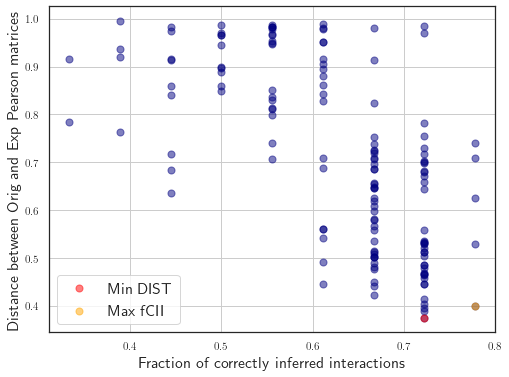

In [37]:
# select models with highest lN_prec_sel_true, fraction of known interactions correctly inferred
Nmodel_mDist = 5
interaction_thr = 0 # we consider all interactions, even with low values
idxs_mDist = np.argsort(lN_dist_MCIf)[:Nmodel_mDist]

for ii in idxs_mDist:
    print ("selected indices:", ii,
           f"CIf value, {lN_prec_sel_MCIf[ii]:.2f}",
           f"Distance value, {lN_dist_MCIf[ii]:.2f}")


plt.figure(figsize=(8,6))
scatter_modelSelection(lN_prec_sel_MCIf, lN_dist_MCIf)
scatter_modelSelection(lN_prec_sel_MCIf[38], lN_dist_MCIf[38], color='red', label="Min DIST")
scatter_modelSelection(lN_prec_sel_MCIf[33], lN_dist_MCIf[33], color='orange', label="Max fCII")


selected indices: 38


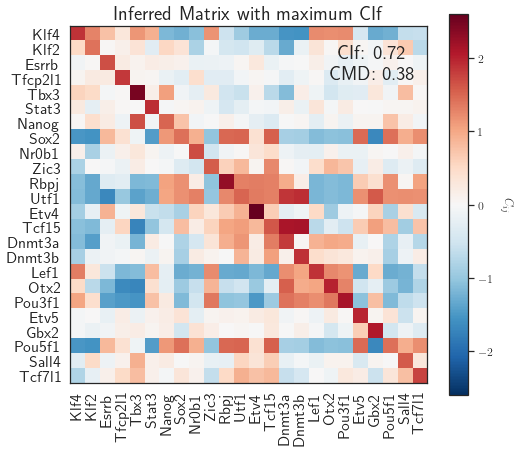

In [34]:
## save the Nmodel_MCIf matrices with the maximum lN_prec_sel_true
Nrow = 1
Ncol = 1
if Ncol ==1:
    Nrow=1
    fig, ax = plt.subplots(nrows=Nrow, ncols=Ncol, figsize=(8,7))
else:
    fig, ax = plt.subplots(nrows=Nrow, ncols=Ncol, figsize=(20, 12))
    
best_model_mDist = np.zeros((lN_matx_sel_MCIf.shape[1], lN_matx_sel_MCIf.shape[2]))
info_best_model_mDist = np.zeros((lN_int_val_MCIf.shape[0], lN_int_val_MCIf.shape[1]))
for ii in range(Nmodel_mDist):
    if idxs_mDist[ii]==38:
        print("selected indices:", idxs_mDist[ii])
        best_model_mDist[:,:] = np.squeeze(lN_matx_sel_MCIf[idxs_mDist[ii],:,:])
        # plot the interaction matrices
        text = "CIf: {:.2f}\nCMD: {:.2f}".format(lN_prec_sel_MCIf[idxs_mDist[ii]], lN_dist_MCIf[idxs_mDist[ii]])   # print the fraction of correctly inferred interactions and the distance

        figfunc.plotmat(best_model_mDist[:,:], fig, ax, genes_order, "Inferred Matrix with maximum CIf", fix=False)
        ax.text(0.85,0.85, text, transform=ax.transAxes, ha='center', fontsize=20)

        # select lN_int_val_true with the maximum lN_prec_sel_true
        info_best_model_mDist[:,:] = lN_int_val_MCIf[:,:, idxs_mDist[ii]]


plt.show()

/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Model Selection: Trial  38

Params for LogNorm (0)
 {'LAMBDA': 0.03, 'lr': 0.6, 'drop': 0.7, 'edrop': 20, 'opt': 'NADAM', 'MOM': 0.95, 'reg': 'L1', 'Nepochs': 500}
Epoch 	 Max J gradient 	 Max h gradient 	 Max change in J 	 Max change in h 	 Likelihood
300 	 0.003955 	 0.000788 	 0.0004 	 0.0001 	 -7.6559


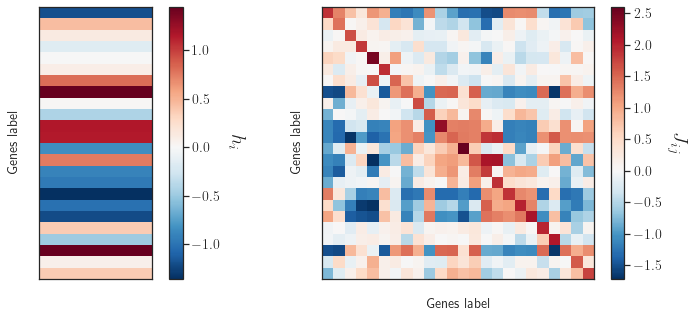

Fraction of correctly inferred interactions: 0.72, distance: 0.38
Distance: 0.38


In [35]:
# Code to save the distance between the original and the simulated matrices for all Ntrials

Ntrials = 50
matx_sel = np.zeros((Ntrials, len(genes_order), len(genes_order)))
info_int  = np.zeros((4, len(TPtrial_list), Ntrials))
tp_val  = np.zeros(Ntrials)
dist  = np.zeros(Ntrials)

N_genes = len(genes_order)
N_ts = 9000 # 9000
N_sim = 10 # 10

cm_original_lN = np.corrcoef(spins_df_lN_mb_pst)
corr_matxs_rnd_lN = np.array([np.corrcoef(spins_df_lN_mb_pst_shuffle[i,:,:]) for i in range(spins_df_lN_mb_pst_shuffle.shape[0])])
noise_dist = np.mean([funcs_ko.sum_squared_abs_diff(cm_original_lN, corr_matxs_rnd_lN[i,:,:]) for i in range(50)])

models_selected = []
np.random.seed(20961)  
for ii in range(Ntrials):
    par_sel = {}
    for jj in params.keys():
        par_sel[jj] = np.random.choice(params[jj])
        
    if ii ==38:
        print("Model Selection: Trial ", ii)
        print("\nParams for LogNorm (0)\n", par_sel)
        
        # model
        model_temp = asynch_reconstruction(np.array(spins_df_lN_mb_pst), delta_t = 1, LAMBDA = par_sel["LAMBDA"], opt = par_sel['opt'], MOM=par_sel["MOM"], reg = 'L1') #opt = 'MOMENTUM', MOM=0.99
        model_temp.reconstruct(np.array(spins_df_lN_mb_pst), Nepochs = par_sel["Nepochs"], start_lr = par_sel["lr"], drop = par_sel["drop"], edrop = par_sel["edrop"])
        print("Fraction of correctly inferred interactions: {:.2f}, distance: {:.2f}".format(lN_prec_sel_MCIf[ii], lN_dist_MCIf[ii]))
        models_selected.append(model_temp) # save the models   
        
        # evaluate the model with the comparison between original and simulated Pearson correlation matrix
        spins_new_lN = np.zeros((N_genes, N_ts, N_sim))
        # generate N_sim new time series of spins using model
        for ll in range(N_sim):
            spins_new_lN[:,:,ll] = model_temp.generate_samples(seed=ll*2, t_size=N_ts)
        # compute the Pearson correlation matrix
        cm_sim_lN = np.zeros((spins_new_lN.shape[0], spins_new_lN.shape[0], spins_new_lN.shape[2]))
        for kk in range(spins_new_lN.shape[2]):
            cm_sim_lN[:,:, kk] = np.corrcoef(spins_new_lN[:,:,kk])
        cm_sim_lN_mean = np.nanmean(cm_sim_lN, axis=2) # mean for simulated correlation matrix

        dist[ii] = np.mean([funcs_ko.sum_squared_abs_diff(cm_original_lN, cm_sim_lN[:,:,i]) for i in range(cm_sim_lN.shape[2])])/ noise_dist # normalize by the noise
        if  np.isnan(cm_sim_lN).sum() > (24*24*spins_new_lN.shape[2])-24*24*0.5*spins_new_lN.shape[2]:
            dist[ii] =np.nan
        print("Distance: {:.2f}".format(dist[ii]))




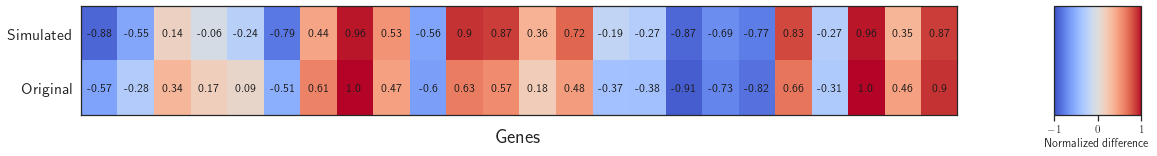

0.9166666666666667


In [36]:
# average per gene of spins_df_lN_mb_pst
avg_spins_df_lN_mb_pst = np.mean(spins_df_lN_mb_pst, axis=1)
avg_spins_df_lN_sim = np.mean(np.mean(spins_new_lN, axis=1), axis=1)
# unique matrix 24x2 with avg_spins_df_lN_mb_pst and avg_spins_df_lN_sim:
funcs_ko.KO_heat_comparison_T(avg_spins_df_lN_sim,avg_spins_df_lN_mb_pst, "", "", Norm=False)

avg_spins_goodness = funcs_ko.fraction_agreement(avg_spins_df_lN_sim, avg_spins_df_lN_mb_pst, genes_order, 0)[3]
print(avg_spins_goodness)

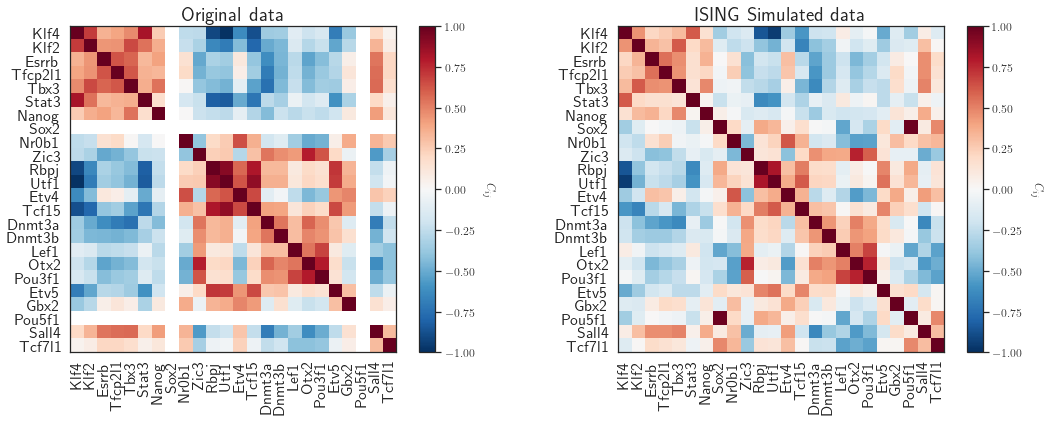

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
# figfunc.plotmat(corr_matxs_rnd_lN_noDiag, fig, ax[0], genes_order, "Random data")
figfunc.plotmat(cm_original_lN, fig, ax[0], genes_order, "Original data", fix = True)

cm_sim_lN_mean = np.nanmean(cm_sim_lN, axis=2)
figfunc.plotmat(cm_sim_lN_mean, fig, ax[1], genes_order, "ISING Simulated data", fix = True)
plt.show()

Model Selection: Trial  0
Fraction of correctly inferred interactions: 0.72


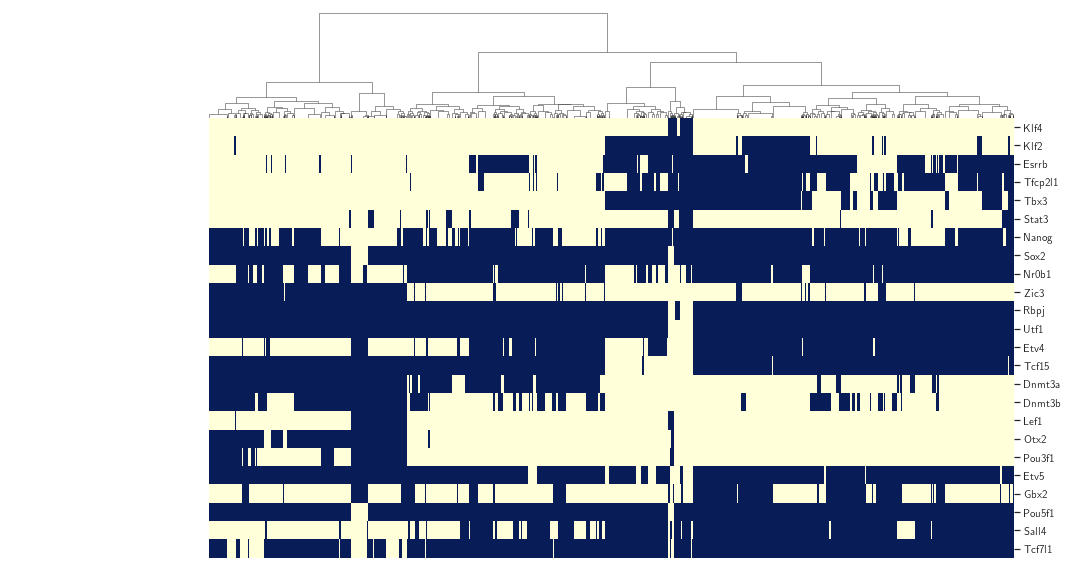

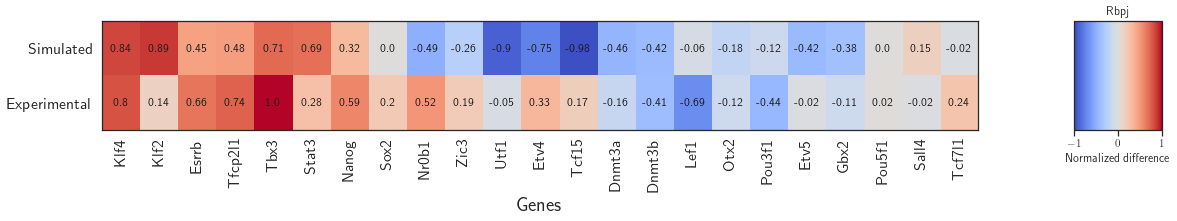

(0.30434782608695654, 0.30434782608695654, 0.043478260869565216, 0.6521739130434783)


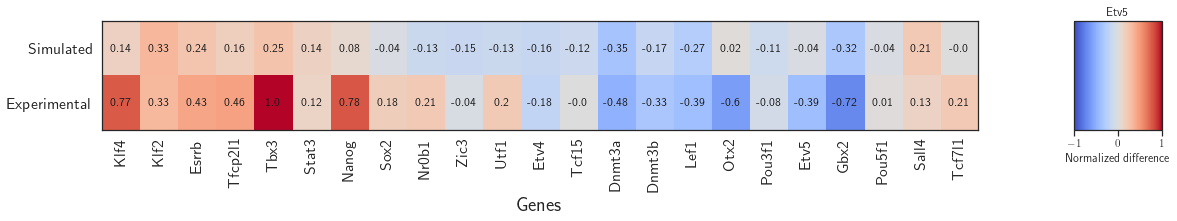

(0.2608695652173913, 0.34782608695652173, 0.043478260869565216, 0.6521739130434783)


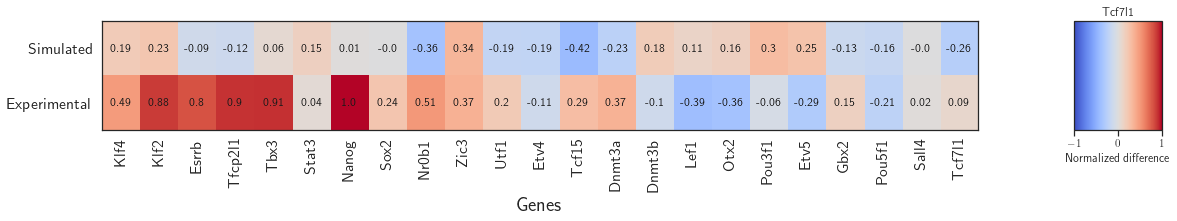

(0.08695652173913043, 0.17391304347826086, 0.043478260869565216, 0.30434782608695654)


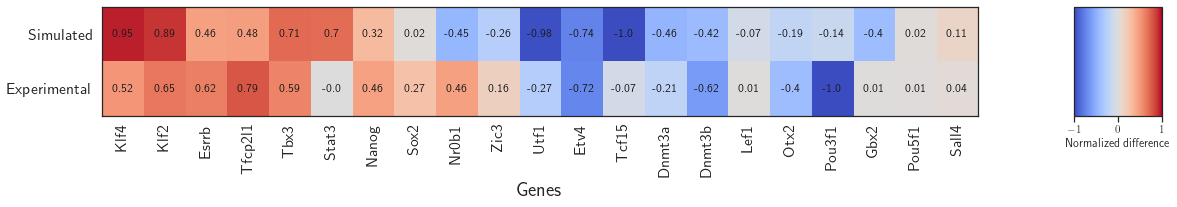

(0.3333333333333333, 0.2857142857142857, 0.047619047619047616, 0.6666666666666667)


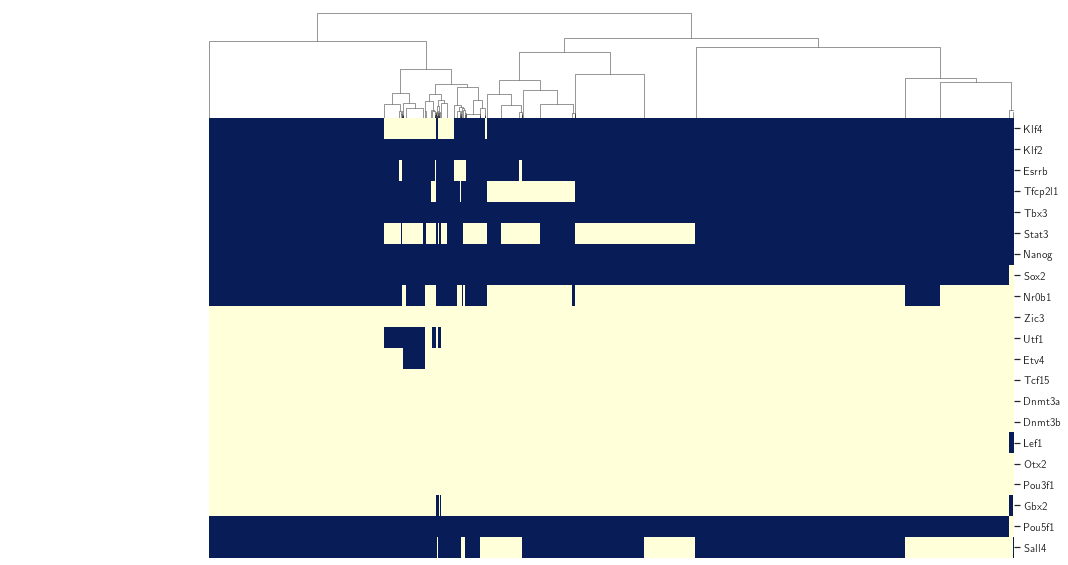

In [54]:
# matx_sel = np.zeros((Ntrials, len(genes_order), len(genes_order)))
# info_int  = np.zeros((4, len(TPtrial_list), Ntrials))
# tp_val  = np.zeros(Ntrials)

N_genes = len(genes_order)
N_ts = 10000
N_sim = 100
N_test_KO = N_sim

spins_new_lN = np.zeros((len(idxs_mDist),N_genes, N_ts, N_sim))
KO_goodness_mDist = np.zeros((len(idxs_mDist), 4))
dist  = np.zeros(Ntrials)

cc=0
for ii in range(Ntrials):        
    if ii in idxs_mDist and ii==36:
        print("Model Selection: Trial ", cc)
        for ll in range(N_sim):
            np.random.seed(ll+1234)
            spins_new_lN[cc,:,:,ll] = models_selected[cc].generate_samples(seed=ll*2, t_size=N_ts)
        print("Fraction of correctly inferred interactions: {:.2f}".format(lN_prec_sel_MCIf[ii]))
             
        # Clustering
        # flat spins_new_lN linearizing the dimension 3 (N_sim)
        # all_spins_temp = np.reshape(spins_new_lN[cc,:,:,:], (spins_new_lN.shape[1], spins_new_lN.shape[2]*spins_new_lN.shape[3]), order='F')
        jj=0 # select one of the simulated datasets
        Z = scipy.cluster.hierarchy.linkage(spins_new_lN[cc,:,:,jj].T, method='ward')
        # Z = scipy.cluster.hierarchy.linkage(all_spins_temp.T, method='ward')
        # Note: we are showing just one simulated dataset, but you can do the same for all of them

        # Plot the dendrogram and heatmap
        sns.clustermap(spins_new_lN[cc,:,:, jj], col_linkage=Z, cmap='YlGnBu',yticklabels=genes_order,cbar=False, figsize=(15,8), row_cluster=False,xticklabels=False )
        # sns.clustermap(all_spins_temp, col_linkage=Z, cmap='YlGnBu',yticklabels=genes_order,cbar=False, figsize=(15,8), row_cluster=False,xticklabels=False )
        plt.xticks([])
        plt.yticks([])
        plt.show()
        
        # Single KO
        # Rbpj
        diff_lN_Rbpj, exp_logFC_Rbpj, KO_genes_order_Rbpj = funcs_ko.KO_wrap("Rbpj", 
                                                                             best_model_mDist[:,:], 
                                                                             models_selected[cc], genes_order, 
                                                                             spins_new_lN[cc,:,:,:], 
                                                                             df_KO_N24_Leeb_uncl,
                                                                             N_test_KO=N_test_KO) 
        
        diff_lN_Etv5, exp_logFC_Etv5, KO_genes_order_Etv5 = funcs_ko.KO_wrap("Etv5", 
                                                                             best_model_mDist[:,:], 
                                                                             models_selected[cc], genes_order, 
                                                                             spins_new_lN[cc,:,:,:], 
                                                                             df_KO_N24_Leeb_uncl, 
                                                                             N_test_KO=N_test_KO)
        
        diff_lN_Tcf7l1, exp_logFC_Tcf7l1, KO_genes_order_Tcf7l1 = funcs_ko.KO_wrap("Tcf7l1", 
                                                                             best_model_mDist[:,:], 
                                                                             models_selected[cc], genes_order, 
                                                                             spins_new_lN[cc,:,:,:], 
                                                                             df_KO_N24_Leeb_uncl, 
                                                                             N_test_KO=N_test_KO)

        # Triple KO
        KO_gene_T_spins = ["Rbpj", "Etv5", "Tcf7l1"]

        KO_lN_rec_matx_T_spins, KO_lN_rec_field_T_spins, KO_gene_idk_T, KO_genes_order_T = funcs_ko.info_KO(best_model_mDist[:,:], models_selected[cc], KO_gene_T_spins,
                                                                                    genes_order=genes_order, multiple=True)
        wt_lN_mb_pst_spins_forKO_T = np.delete(np.array(spins_new_lN[cc,:,:,:]),KO_gene_idk_T, axis=0)+1

        # generate KO activity
        KO_T_spins = funcs_ko.KO_activity_sim(KO_lN_rec_matx_T_spins, KO_lN_rec_field_T_spins, KO_genes_order_T, models_selected[cc], N_test_KO=50, n_time=10000)
        # average activity for KO and wt
        KO_T_weighted_avg, KO_T_weighted_std, wt_T_avg, wt_T_std = funcs_ko.KO3_avg_weighted(KO_T_spins+1, wt_lN_mb_pst_spins_forKO_T)


        # remove row of the KO
        df_tKO_Kalkan_sel =df_tKO_Kalkan.drop(["Etv5","Rbpj", "Tcf7l1"])
        # search gene present in genes_order and absent in df_tKO_Kalkan_sel and thei indices
        common_genes = [x for x in KO_genes_order_T if x in df_tKO_Kalkan_sel.index]
        common_genes_idx = [x for x in range(len(KO_genes_order_T)) if KO_genes_order_T[x] in df_tKO_Kalkan_sel.index]

        # select only simulated KO and WT for which we know experimental tKO
        KO_T_weighted_avg_sel_T = KO_T_weighted_avg[common_genes_idx]
        KO_T_weighted_std_sel_T = KO_T_weighted_std[common_genes_idx]
        wt_T_avg_sel_T = wt_T_avg[common_genes_idx]
        wt_T_std_sel_T = wt_T_std[common_genes_idx]

        diff_sim_T, _, _ = funcs_ko.KO_diff_sim(KO_T_weighted_avg_sel_T, KO_T_weighted_std_sel_T ,wt_T_avg_sel_T, wt_T_std_sel_T, thr_significance=3)

        #### Normalized differences
        diff_sim   = np.array([diff_lN_Rbpj, diff_lN_Etv5, diff_lN_Tcf7l1])
        log2FC_exp = np.array([exp_logFC_Rbpj, exp_logFC_Etv5, exp_logFC_Tcf7l1])
        genes_KOs  = np.array([KO_genes_order_Rbpj, KO_genes_order_Etv5, KO_genes_order_Tcf7l1])

        diff_max = max(np.abs(diff_sim).max(), np.abs(diff_sim_T).max())
        diff_sim_norm = diff_sim/diff_max
        diff_sim_T_norm = diff_sim_T/diff_max

        log2FC_exp_norm = log2FC_exp/np.abs(log2FC_exp).max()
        df_tKO_Kalkan_norm = df_tKO_Kalkan_sel/np.abs(df_tKO_Kalkan_sel).max()

        diff_thr = 0.05
        # Rbpj
        funcs_ko.KO_heat_comparison_T(diff_sim_norm[0,:], log2FC_exp_norm[0,:], "Rbpj", genes_KOs[0,:], Norm=False)
        print(funcs_ko.fraction_agreement(diff_sim_norm[0,:], log2FC_exp_norm[0,:], genes_KOs[0,:], diff_thr))
        KO_goodness_mDist[cc,0] = funcs_ko.fraction_agreement(diff_sim_norm[0,:], log2FC_exp_norm[0,:], genes_KOs[0,:], diff_thr)[3]
        # Etv5
        funcs_ko.KO_heat_comparison_T(diff_sim_norm[1,:], log2FC_exp_norm[1,:], "Etv5", genes_KOs[0,:], Norm=False)
        print(funcs_ko.fraction_agreement(diff_sim_norm[1,:], log2FC_exp_norm[1,:], genes_KOs[1,:], diff_thr))
        KO_goodness_mDist[cc,1] = funcs_ko.fraction_agreement(diff_sim_norm[1,:], log2FC_exp_norm[1,:], genes_KOs[1,:], diff_thr)[3]

        # Tcf7l1
        funcs_ko.KO_heat_comparison_T(diff_sim_norm[2,:], log2FC_exp_norm[2,:], "Tcf7l1", genes_KOs[0,:], Norm=False)
        print(funcs_ko.fraction_agreement(diff_sim_norm[2,:], log2FC_exp_norm[2,:], genes_KOs[2,:], diff_thr))
        KO_goodness_mDist[cc,2] = funcs_ko.fraction_agreement(diff_sim_norm[2,:], log2FC_exp_norm[2,:], genes_KOs[2,:], diff_thr)[3]

        # Triple
        funcs_ko.KO_heat_comparison_T(diff_sim_T_norm, np.array(df_tKO_Kalkan_sel).squeeze(), "", np.array(common_genes), Norm=False)
        print(funcs_ko.fraction_agreement(diff_sim_T_norm, np.array(df_tKO_Kalkan_norm).squeeze(), np.array(common_genes), diff_thr))
        KO_goodness_mDist[cc,3] = funcs_ko.fraction_agreement(diff_sim_T_norm, np.array(df_tKO_Kalkan_norm).squeeze(), np.array(common_genes), diff_thr)[3]

        jj = 0
        # Perform linkage on your numpy array
        Z = scipy.cluster.hierarchy.linkage(KO_T_spins[:,:,jj].T, method='ward')
        sns.clustermap(KO_T_spins[:,:,jj], col_linkage=Z, cmap='YlGnBu',
                    yticklabels=KO_genes_order_T, xticklabels=[],
                    cbar=False, figsize=(15,8), row_cluster=False )
        plt.xticks([])
        plt.yticks([])
        plt.show()
        
        cc+=1


In [ ]:
# # Code to save the distance between the original and the simulated matrices for all Ntrials

# Ntrials = 150
# matx_sel = np.zeros((Ntrials, len(genes_order), len(genes_order)))
# info_int  = np.zeros((4, len(TPtrial_list), Ntrials))
# tp_val  = np.zeros(Ntrials)
# dist  = np.zeros(Ntrials)

# N_genes = len(genes_order)
# N_ts = 9000
# N_sim = 10

# cm_original_lN = np.corrcoef(spins_df_lN_mb_pst)
# corr_matxs_rnd_lN = np.array([np.corrcoef(spins_df_lN_mb_pst_shuffle[i,:,:]) for i in range(spins_df_lN_mb_pst_shuffle.shape[0])])
# noise_dist = np.mean([funcs_ko.sum_squared_abs_diff(cm_original_lN, corr_matxs_rnd_lN[i,:,:]) for i in range(50)])

# np.random.seed(20961)  
# for ii in range(Ntrials):
#     print("Model Selection: Trial ", ii)
#     par_sel = {}
#     for jj in params.keys():
#         par_sel[jj] = np.random.choice(params[jj])
#     print(par_sel)
#     # model
#     model_temp = asynch_reconstruction(np.array(spins_df_lN_mb_pst), delta_t = 1, LAMBDA = par_sel["LAMBDA"], opt = par_sel['opt'], MOM=par_sel["MOM"], reg = 'L1') #opt = 'MOMENTUM', MOM=0.99
#     model_temp.reconstruct(np.array(spins_df_lN_mb_pst), Nepochs = par_sel["Nepochs"], start_lr = par_sel["lr"], drop = par_sel["drop"], edrop = par_sel["edrop"])
#     # evaluate the model with the comparison between original and simulated Pearson correlation matrix
#     spins_new_lN = np.zeros((N_genes, N_ts, N_sim))
#     # generate N_sim new time series of spins using model
#     for ll in range(N_sim):
#         spins_new_lN[:,:,ll] = model_temp.generate_samples(seed=ll*2, t_size=N_ts)
#     # compute the Pearson correlation matrix
#     cm_sim_lN = np.zeros((spins_new_lN.shape[0], spins_new_lN.shape[0], spins_new_lN.shape[2]))
#     for kk in range(spins_new_lN.shape[2]):
#         cm_sim_lN[:,:, kk] = np.corrcoef(spins_new_lN[:,:,kk])
#     cm_sim_lN_mean = np.nanmean(cm_sim_lN, axis=2) # mean for simulated correlation matrix

#     dist[ii] = np.mean([funcs_ko.sum_squared_abs_diff(cm_original_lN, cm_sim_lN[:,:,i]) for i in range(cm_sim_lN.shape[2])])/ noise_dist # normalize by the noise
#     if  np.isnan(cm_sim_lN).sum() > (24*24*spins_new_lN.shape[2])-24*24*0.5*spins_new_lN.shape[2]:
#         dist[ii] =np.nan
#     print("Distance: {:.2f}".format(dist[ii]))
    
#     if ii==33:
#         print("\nParams for LogNorm (0)\n", par_sel)
#     if ii==56:
#         print("\nParams for  LogNorm (1)\n", par_sel)
#     if ii==77:
#         print("\nParams for  LogNorm (2)\n", par_sel)
#     if ii==92:
#         print("\nParams for  LogNorm (3)\n", par_sel)
#     if ii==117:
#         print("\nParams for  LogNorm (4)\n", par_sel)

# np.savez(path_data+'OUT_ISING/LogNORM/dist_CIf_'+data_type+'_'+str(today)+'.npz', dist)


